In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
def save_notebook():
    return display(Javascript("IPython.notebook.save_notebook()"),
                   include=['application/javascript'])

def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [4]:
import sys, os
import glob
import warnings
sys.path.append('../')

from rankutils.mappings import ranking_type_map, exp_aliases
from rankutils.cfgloader import cfgloader
from rankutils.evaluation import parsecolor
from rankutils.drawing import colors_from_cmap, irp_results_barh_draw, irp_results_pos_draw, rpp_results_draw

from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, confusion_matrix, average_precision_score, precision_score

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import seaborn as sns
sns.set()

from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange

import mpld3

In [5]:
def draw_eval_curve(x, y, xlabel, ylabel, ax=None, **drawargs):
    
    if not ax:
        ax = plt.gca()

    line, = ax.plot(x, y, fillstyle='full', **drawargs)
    
    ax.set_ylim(bottom=0.0, top=1.0)
    ax.set_yticks([y for y in np.arange(0.0, 1.1, 0.2)])
    ax.set_yticklabels(["{0:0.1f}".format(y) for y in np.arange(0.0, 1.1, 0.2)], fontdict=dict(fontsize=12))
    if ylabel:
        ax.set_ylabel(ylabel, fontdict=dict(fontsize=12))
        
    ax.set_xlim(left=1.0, right=k)
    ax.set_xticks([x for x in np.arange(1, x.size+1, 1)])
    ax.set_xticklabels(["{0:d}".format(x) for x in np.arange(1, k + 1, 1)], fontdict=dict(fontsize=8))
    if xlabel:
        ax.set_xlabel(xlabel, fontdict=dict(fontsize=12))
        
    return

In [6]:
def draw_eval_bars(x, y, xtl, xlabel, ylabel, drawargs_l, ax=None):
    
    if not ax:
        ax = plt.gca()
        
    for i in range(len(x)):
        rect, = ax.bar(x[i], y[i], width=0.8, bottom=0, color=drawargs_l[i]['color'], 
                       label=drawargs_l[i]['label'], alpha=0.8)
        
        posx = rect.get_x()
        posy = rect.get_y()
        hgt = rect.get_height()
        wdt = rect.get_width()
        
        print([x[i], posx, posy, hgt, wdt])
        
        ax.text(posx, posy + 0.01, "{0:0.3f}".format(y[i]), fontsize=13, bbox={'alpha': 0.0},
                color='white', fontweight='bold', horizontalalignment='left')
    
    
    ax.set_ylim(bottom=-1.0, top=1.0)
    ax.set_yticks(np.arange(-1.0, 1.1, 0.2))
    ax.set_yticklabels(["{0:0.1f}".format(y) for y in np.arange(-1.0, 1.1, 0.2)])
    if ylabel:
        ax.set_ylabel(ylabel, fontdict=dict(fontsize=12))
        
    ax.set_xlim(left=0.5, right=x[-1]+0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(xtl)
    if xlabel:
        ax.set_xlabel(xlabel, fontdict=dict(fontsize=12))
        
    return
    

In [7]:
def evaluate(gtpath, predpath, k):
        
    gt = np.load(gtpath)
    p = np.load(predpath)
    
    #print(gt.shape)
    #print(p.shape)
    
    if p.ndim == 2:
        r = p.shape[0]
        p = p.reshape(1, r, -1)
        
    nrounds = p.shape[0]
    
    bacc_eval = np.zeros((nrounds, k), dtype=np.float64)
    tpr_eval = np.zeros((nrounds, k), dtype=np.float64)
    tnr_eval = np.zeros((nrounds, k), dtype=np.float64)
    mcc_eval = np.zeros((nrounds, k), dtype=np.float64)
    
    mcc_all = np.zeros(nrounds, dtype=np.float64)
    
    for r in range(nrounds):
        pr = p[r]
        
        for i in range(k):
            
            y_true = gt[:, i]
            y_pred = pr[:, i]
            
            bacc_eval[r, i] = balanced_accuracy_score(y_true, y_pred)
            mcc_eval[r, i] = matthews_corrcoef(y_true, y_pred)
            
            cfmat = confusion_matrix(y_true, y_pred)
            
            if cfmat.size > 1:
                tn, fp, fn, tp = cfmat.ravel()
                tpr_eval[r, i] = tp/(tp + fn)
                tnr_eval[r, i] = tn/(tn + fp)
            else:
                if y_true[0] == 1:
                    tpr_eval[r, i] = 1.0
                    tnr_eval[r, i] = 1.0
            
        y_true = gt[:, 0:k].reshape(-1)
        y_pred = pr.reshape(-1)
        
        mcc_all[r] = matthews_corrcoef(y_true, y_pred)
            
    return bacc_eval, tpr_eval, tnr_eval, mcc_eval, mcc_all

In [8]:
def evaluate_itv(gtpath, predpath, s, k):
        
    gt = np.load(gtpath)
    p = np.load(predpath)
    
    #print(gt.shape)
    #print(p.shape)
    
    if p.ndim == 2:
        r = p.shape[0]
        p = p.reshape(1, r, -1)
        
    nrounds = p.shape[0]
    
    bacc_eval = np.zeros((nrounds, k-s), dtype=np.float64)
    tpr_eval = np.zeros((nrounds, k-s), dtype=np.float64)
    tnr_eval = np.zeros((nrounds, k-s), dtype=np.float64)
    mcc_eval = np.zeros((nrounds, k-s), dtype=np.float64)
    ppv_eval = np.zeros((nrounds, k-s), dtype=np.float64)
    
    mcc_all = np.zeros(nrounds, dtype=np.float64)
    
    for r in range(nrounds):
        pr = p[r]
        
        for i in range(s, k):
            
            y_true = gt[:, i]
            y_pred = pr[:, i]
            
            bacc_eval[r, i-s] = balanced_accuracy_score(y_true, y_pred)
            mcc_eval[r, i-s] = matthews_corrcoef(y_true, y_pred)
            
            v = precision_score(y_true, y_pred)
            if np.isnan(v):
                ppv_eval[r, i-s] = 0
            else:
                ppv_eval[r, i-s] = v
            
            cfmat = confusion_matrix(y_true, y_pred)
            
            if cfmat.size > 1:
                tn, fp, fn, tp = cfmat.ravel()
                tpr_eval[r, i-s] = tp/(tp + fn)
                tnr_eval[r, i-s] = tn/(tn + fp)
            else:
                if y_true[0] == 1:
                    tpr_eval[r, i-s] = 1.0
                    tnr_eval[r, i-s] = 1.0
            
        y_true = gt[:, s:k].reshape(-1)
        y_pred = pr[:, s:k].reshape(-1)
        
        mcc_all[r] = matthews_corrcoef(y_true, y_pred)
            
    return bacc_eval, tpr_eval, tnr_eval, mcc_eval, ppv_eval, mcc_all

In [9]:
pathcfg = cfgloader("/home/alberto/phD/projects/performance_prediction/ret-mr-learning/source/path_2.cfg")
evalcfg = cfgloader("/home/alberto/phD/projects/performance_prediction/ret-mr-learning/source/evalcfg/thesis/0001.eval_stat.cfg")
barfigsize=(20, 8)
linefigsize=(15, 15)
titleargs=dict(fontsize=10, horizontalalignment='center')
k = 10
s = 1

In [10]:
results = dict()

#keys = ['oxford_004']
keys = ['oxford_001', 'oxford_002', 'oxford_003', 'oxford_004', 'oxford_005']
keys += ['unicamp_001', 'unicamp_002', 'unicamp_003', 'unicamp_004', 'unicamp_005']
keys += ['corel_001', 'corel_002']
keys += ['places365_001', 'places365_002', 'places365_003']
keys += ['vggfaces_001', 'vggfaces_002']
keys += ['imagenet_001', 'imagenet_002']


n = len(keys)

methods = [m for m in evalcfg if m != 'DEFAULT']



with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for key in tqdm(keys, desc='Key ', total=len(keys)):
        
        results[key] = dict()
        
        for m in tqdm(evalcfg.sections(), desc='  .method', total=len(methods)):
            
            rktpdir = pathcfg.get(key, 'rktpdir')
            
            try:
                gtpath = glob.glob("{0:s}/*{1:s}*".format(pathcfg.get(key, 'label'), rktpdir))[0]
                predpath = glob.glob("{0:s}/{1:s}/*irp.npy".format(pathcfg.get(key, 'output'), m))[0]
            except IndexError:
                print(key, m)
                raise

            #results[key][m] = evaluate(gtpath, predpath, k)
            results[key][m] = evaluate_itv(gtpath, predpath, s, k)

# Positional nACC

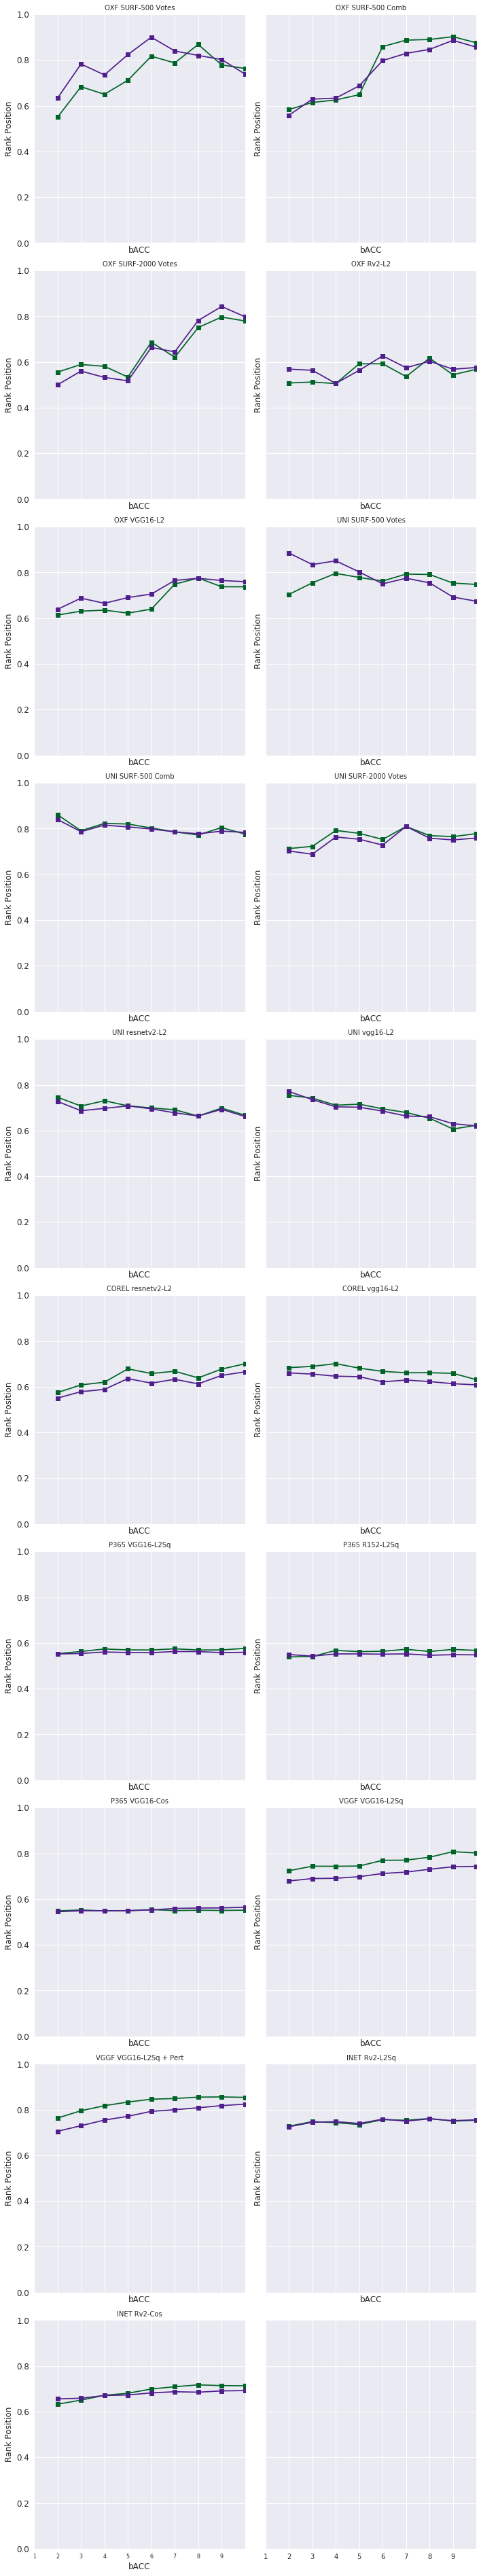

In [11]:
fig, axes = plt.subplots(int(np.ceil(n/2)), 2, sharey=True, sharex=True)
axes = axes.reshape(-1)
fig.set_size_inches((10, n/2*6))
    
for i, key in enumerate(keys):
    axes[i].set_title("{0:s}".format(exp_aliases[key]), fontdict=titleargs)
    
    for m in sorted(results[key]):
        
        drawargs=dict()
        for arg in evalcfg[m]:
            if arg not in evalcfg.defaults():
                
                if arg == 'color':
                    drawargs['color'] = parsecolor(evalcfg.get(m, 'color'))
                else:
                    drawargs[arg] = evalcfg.get(m, arg)
        
        x = np.arange(1+s, k+1)
        y = np.mean(results[key][m][0], axis=0)
        
        
        
        draw_eval_curve(x, y, 'bACC', 'Rank Position', axes[i], **drawargs)
            

fig.tight_layout()
plt.subplots_adjust(top=0.92)
#plt.savefig('/home/alberto/Dropbox/ICASSP-2019_ML_Relevance_Prediction/tex/figures/ICASSP_2019_Pos-NACC.svg')

# MCC

[1, 0.6, 0, 0.5911002376091735, 0.8]
[2, 1.6, 0, 0.6369660049896119, 0.8]
[1, 0.6, 0, 0.6661815815767408, 0.8]
[2, 1.6, 0, 0.6377610939509963, 0.8]
[1, 0.6, 0, 0.4653865583263929, 0.8]
[2, 1.6, 0, 0.4832008822870149, 0.8]
[1, 0.6, 0, 0.1178707141340765, 0.8]
[2, 1.6, 0, 0.1658423135515894, 0.8]
[1, 0.6, 0, 0.4077221691033429, 0.8]
[2, 1.6, 0, 0.4920919736656556, 0.8]
[1, 0.6, 0, 0.6140077911483046, 0.8]
[2, 1.6, 0, 0.6352838933905138, 0.8]
[1, 0.6, 0, 0.6633371510689428, 0.8]
[2, 1.6, 0, 0.6512170660001437, 0.8]
[1, 0.6, 0, 0.6060526560753965, 0.8]
[2, 1.6, 0, 0.5795558612230074, 0.8]
[1, 0.6, 0, 0.4595056043315286, 0.8]
[2, 1.6, 0, 0.4272894460552785, 0.8]
[1, 0.6, 0, 0.4772365297536417, 0.8]
[2, 1.6, 0, 0.4525300765087586, 0.8]
[1, 0.6, 0, 0.2922307977085091, 0.8]
[2, 1.6, 0, 0.23468231189902783, 0.8]
[1, 0.6, 0, 0.4168913210230517, 0.8]
[2, 1.6, 0, 0.3348856229184502, 0.8]
[1, 0.6, 0, 0.17053168138645464, 0.8]
[2, 1.6, 0, 0.15223030770263873, 0.8]
[1, 0.6, 0, 0.1260975600873988, 0.8

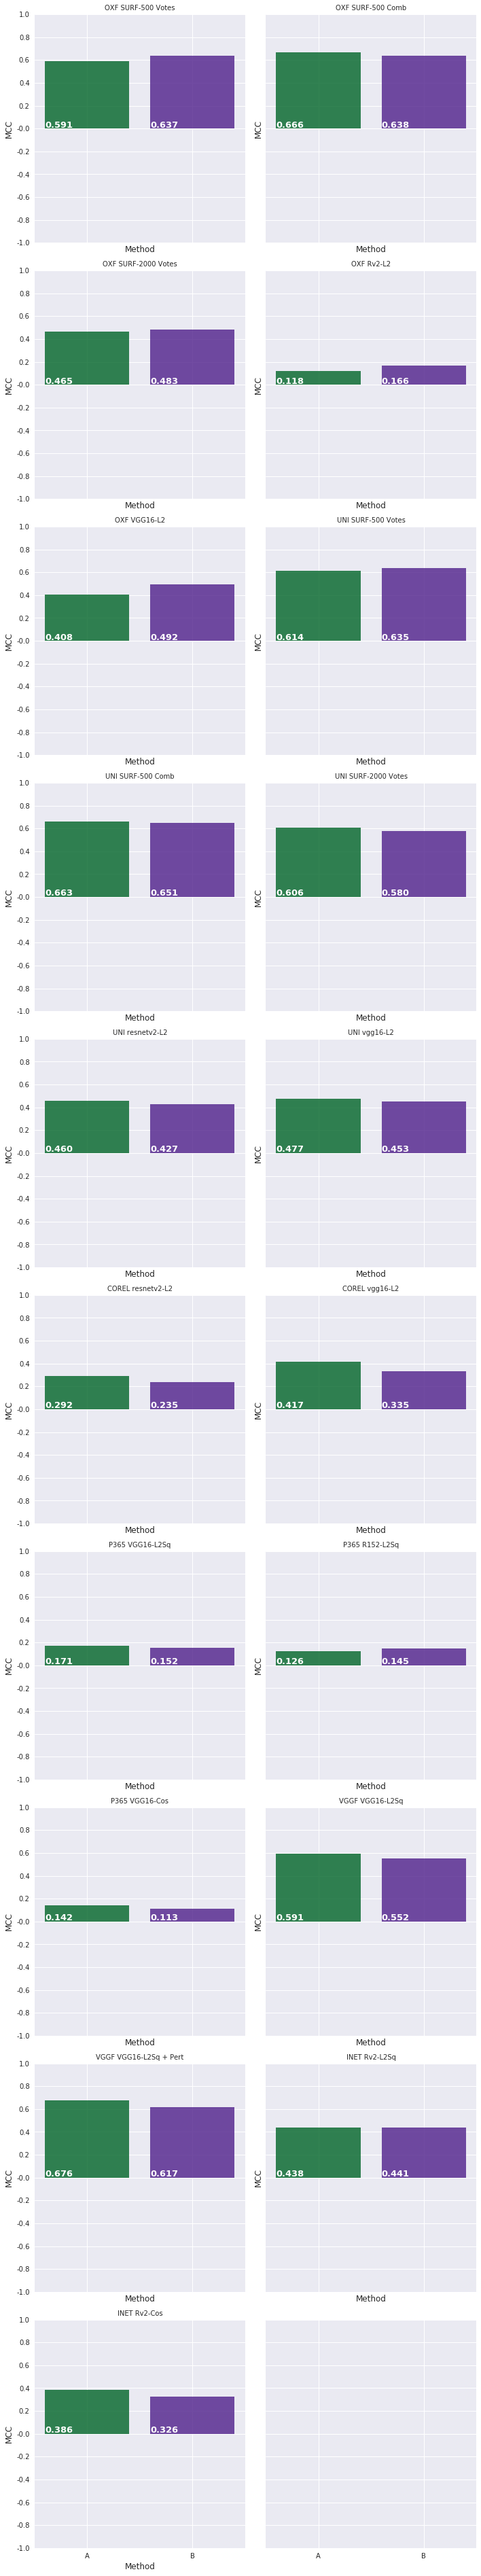

In [12]:
from string import ascii_uppercase

nrows = int(np.ceil(n/2))
fig, axes = plt.subplots(nrows, 2, sharey=True, sharex=True)
try:
    axes = axes.reshape(-1)
except AttributeError:
    axes = [axes]
fig.set_size_inches((10, n*3))
    
for i, key in enumerate(keys):
    axes[i].set_title("{0:s}".format(exp_aliases[key]), fontdict=titleargs)
    
    y = []
    drawargs_l = []
    xtl = []
    
    for m in sorted(results[key]):
        
        drawargs=dict()
        for arg in evalcfg[m]:
            if arg not in evalcfg.defaults():
                
                if arg == 'color':
                    drawargs['color'] = parsecolor(evalcfg.get(m, 'color'))
                else:
                    drawargs[arg] = evalcfg.get(m, arg)
                    
        drawargs_l.append(drawargs)
        #print(results[key][m][-1])
        y.append(np.mean(results[key][m][-1], axis=0))
        
    x = [v for v in range(1, len(y)+1)]
    xtl = [l for l in ascii_uppercase[0:len(y)]]
    
    #print(x)
    #print(y)
    #print(xtl)
    
    draw_eval_bars(x, y, xtl, 'Method', 'MCC', drawargs_l, ax=axes[i])
            

fig.tight_layout()
plt.subplots_adjust(top=0.92)